In [ ]:
# default_exp callback

# Callback

> Callbacks for timeseriesAI.

In [ ]:
#export 
from tsai.imports import *
from tsai.utils import *
from tsai.data.transforms import *
from tsai.models.layers import *
from fastai.callback.all import *

In [ ]:
#export
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

https://dev.fast.ai/callback.core#Callback

## Events: 

A callback can implement actions on the following events:
* before_fit: called before doing anything, ideal for initial setup.
* before_epoch: called at the beginning of each epoch, useful for any behavior you need to reset at each epoch.
* before_train: called at the beginning of the training part of an epoch.
* before_batch: called at the beginning of each batch, just after drawing said batch. It can be used to do any setup necessary for the batch (like hyper-parameter scheduling) or to change the input/target before it goes in the model (change of the input with techniques like mixup for instance).
* after_pred: called after computing the output of the model on the batch. It can be used to change that output before it's fed to the loss.
* after_loss: called after the loss has been computed, but before the backward pass. It can be used to add any penalty to the loss (AR or TAR in RNN training for instance).
* before_backward: called after the loss has been computed, but only in training mode (i.e. when the backward pass will be used)
* after_backward: called after the backward pass, but before the update of the parameters. It can be used to do any change to the gradients before said update (gradient clipping for instance).
* after_step: called after the step and before the gradients are zeroed.
* after_batch: called at the end of a batch, for any clean-up before the next one.
* after_train: called at the end of the training phase of an epoch.
* before_validate: called at the beginning of the validation phase of an epoch, useful for any setup needed specifically for validation.
* after_validate: called at the end of the validation part of an epoch.
* after_epoch: called at the end of an epoch, for any clean-up before the next one.
* after_fit: called at the end of training, for final clean-up.

## Learner attributes:

When writing a callback, the following attributes of Learner are available:

* **model**: the model used for training/validation
* **data**: the underlying DataLoaders
* **loss_func**: the loss function used
* **opt**: the optimizer used to udpate the model parameters
* **opt_func**: the function used to create the optimizer
* **cbs**: the list containing all Callbacks
* **dl**: current DataLoader used for iteration
* **x/xb**: last input drawn from self.dl (potentially modified by callbacks). xb is always a tuple (potentially with one element) and x is detuplified. You can only assign to xb.
* **y/yb**: last target drawn from self.dl (potentially modified by callbacks). yb is always a tuple (potentially with one element) and y is detuplified. You can only assign to yb.
* **pred**: last predictions from self.model (potentially modified by callbacks)
* **loss**: last computed loss (potentially modified by callbacks)
* **n_epoch**: the number of epochs in this training
* **n_iter**: the number of iterations in the current self.dl
* **epoch**: the current epoch index (from 0 to n_epoch-1)
* **iter**: the current iteration index in self.dl (from 0 to n_iter-1)

The following attributes are added by TrainEvalCallback and should be available unless you went out of your way to remove that callback:
* **train_iter**: the number of training iterations done since the beginning of this training
* **pct_train**: from 0. to 1., the percentage of training iterations completed
* **training**: flag to indicate if we're in training mode or not

The following attribute is added by Recorder and should be available unless you went out of your way to remove that callback:
* **smooth_loss**: an exponentially-averaged version of the training loss

## Gambler's loss: noisy labels

In [ ]:
#export
class GamblersCallback(Callback):
    "A callback to use metrics with gambler's loss"
    def after_loss(self): self.learn.pred = self.learn.pred[..., :-1]

In [ ]:
from tsai.data.all import *
from tsai.models.InceptionTime import *
from tsai.models.layers import *
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True, return_split=False)
tfms = [None, Categorize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
loss_func = gambler_loss()
learn = Learner(dls, InceptionTime(dls.vars, dls.c + 1), loss_func=loss_func, cbs=GamblersCallback, metrics=[accuracy])
learn.fit_one_cycle(1)

Dataset: NATOPS
X      : (360, 24, 51)
y      : (360,)
splits : ((#180) [0,1,2,3,4,5,6,7,8,9...], (#180) [180,181,182,183,184,185,186,187,188,189...]) 



epoch,train_loss,valid_loss,accuracy,time
0,1.575226,1.553405,0.166667,00:06


## Noisy student: self-training (pseudolabels)

In [ ]:
#export
@log_args
class NoisyStudent(Callback):
    """A callback to implement the Noisy Student approach. In the original paper this was used in combination with noise: 
        - stochastic depth: .8
        - RandAugment: N=2, M=27
        - dropout: .5
        
    Steps:
        1. Build the dl you will use as a teacher
        2. Create dl2 with the unlabeled data plus pseudolabels (either soft or hard preds)
        3. Pass any required batch_tfms to the callback
    
    """
    
    def __init__(self, dl2:DataLoader, bs:Union[None, int]=None, unlabel_ratio:int=1, batch_tfms:Union[None, list]=None, do_setup:bool=True, 
                 unlabeled_sample_weight:float=1., verbose=False): 
        self.dl2, self.bs, self.unlabel_ratio, self.batch_tfms, self.do_setup, self.vebose = dl2, bs, unlabel_ratio, batch_tfms, do_setup, verbose
        self.unlabeled_sample_weight = unlabeled_sample_weight
        
    def before_fit(self):
        # Remove and store dl.train.batch_tfms
        self.old_train_dl_batch_tfms = self.dls.train.after_batch
        self.dls.train.after_batch = noop        

        if self.do_setup and self.batch_tfms:
            for bt in self.batch_tfms: bt.setup(self.dls.train)

        unlabel_ratio = self.unlabel_ratio
        dsets_ratio = len(self.dl2.dataset) / len(self.dls.train.dataset)
        if dsets_ratio < self.unlabel_ratio:  self.unlabel_ratio = dsets_ratio
        if self.bs is None: self.bs = self.dls.train.bs
        self.dl2.bs = min(len(self.dl2.dataset), int(self.unlabel_ratio * self.bs / (1 + self.unlabel_ratio)))
        self.dls.train.bs = self.bs - self.dl2.bs
        if unlabel_ratio != self.dl2.bs/self.dls.train.bs: 
            print(f'effective unlabel_ratio          : {unlabel_ratio:.3f} --> {self.dl2.bs/self.dls.train.bs:.3f} \
            dl.bs: {self.dls.train.bs}  dl2.bs: {self.dl2.bs}')
        print(f'relative unlabeled sample weight : {self.dl2.bs/self.dls.train.bs * len(self.dls.train.dataset) / len(self.dl2.dataset):.3f}')
        self.dl2iter = iter(self.dl2)
    
        self.old_loss_func = self.learn.loss_func
        self.learn.loss_func = self.loss
        
    def before_batch(self):
        if self.training:
            X, y = self.x, self.y
            try: X2, y2 = next(self.dl2iter)
            except StopIteration:
                self.dl2iter = iter(self.dl2)
                X2, y2 = next(self.dl2iter)
            if y.ndim == 1 and y2.ndim == 2: y = torch.eye(self.learn.dls.c)[y].to(device)
            pv(f'X: {X.shape}  X2: {X2.shape}  y: {y.shape} y2: {y2.shape}', self.vebose)
            X_comb = concat(X, X2) # concat and retain type for tfms
            y_comb = concat(y, y2)
#             perm = torch.randperm(y_comb.shape[0])
#             X_combv = X_comb[perm]
#             y_comb = y_comb[perm]
            if self.batch_tfms is not None: 
                X_comb = compose_tfms(X_comb, self.batch_tfms, split_idx=0)
                y_comb = compose_tfms(y_comb, self.batch_tfms, split_idx=0)
            self.learn.xb = (X_comb,)
            self.learn.yb = (y_comb,)
            pv(f'X: {X.shape}  X2: {X2.shape}  X_comb: {X_comb.shape}', self.vebose)
            
    def loss(self, output, target): 
        if target.ndim == 2: _, target = target.max(dim=1)
        if self.training and self.unlabeled_sample_weight != 1: 
            loss = (1 - self.unlabeled_sample_weight) * self.old_loss_func(output[:self.dls.train.bs], target[:self.dls.train.bs])
            loss += self.unlabeled_sample_weight * self.old_loss_func(output[self.dls.train.bs:], target[self.dls.train.bs:])
            return loss 
        else: 
            return self.old_loss_func(output, target)
    
    def after_fit(self):
        self.dls.train.after_batch = self.old_train_dl_batch_tfms
        self.learn.loss_func = self.old_loss_func
        self.dls.train.bs = self.bs
        self.dls.bs = self.bs

In [ ]:
from tsai.data.all import *
from tsai.models.InceptionTime import *
from tsai.models.layers import *
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True, return_split=False)

Dataset: NATOPS
X      : (360, 24, 51)
y      : (360,)
splits : ((#180) [0,1,2,3,4,5,6,7,8,9...], (#180) [180,181,182,183,184,185,186,187,188,189...]) 



In [ ]:
tfms = [None, Categorize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
batch_tfms = None
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=batch_tfms)
first(dls.train)

(TSTensor(samples:64, vars:24, len:51),
 TensorCategory([0, 5, 4, 4, 0, 4, 4, 5, 3, 3, 1, 1, 5, 3, 2, 2, 2, 0, 0, 4, 1, 0, 3, 2,
         5, 1, 5, 5, 0, 1, 3, 4, 1, 0, 3, 2, 0, 4, 1, 5, 1, 5, 5, 5, 1, 2, 2, 3,
         3, 0, 0, 0, 3, 5, 3, 4, 5, 1, 2, 5, 1, 4, 1, 0]))

In [ ]:
unlabeled_data = X
pseudolabels = ToNumpyCategory()(y) # one-hot to simulate soft preds, but also work with hard preds!
pseudolabels = OneHot()(y) # one-hot to simulate soft preds, but also work with hard preds!
dsets2 = TSDatasets(unlabeled_data, pseudolabels)
dl2 = TSDataLoader(dsets2, bs=4, num_workers=0)
test_eq(torch.equal(first(dl2)[0], TSTensor(unlabeled_data[dl2.input_idxs])), True)

In [ ]:
cbs = []
noisy_student = NoisyStudent(dl2, unlabel_ratio=4, batch_tfms=[TSStandardize(), TSRandomSize(.5)], verbose=True)
cbs += [noisy_student]

In [ ]:
learn = Learner(dls, InceptionTime(dls.vars, dls.c), loss_func=LabelSmoothingCrossEntropy(), cbs=cbs, metrics=[accuracy])
learn.cbs

(#4) [TrainEvalCallback,Recorder,ProgressCallback,NoisyStudent]

In [ ]:
learn.fit_one_cycle(1)

effective unlabel_ratio          : 4.000 --> 1.909             dl.bs: 22  dl2.bs: 42
relative unlabeled sample weight : 0.955


epoch,train_loss,valid_loss,accuracy,time
0,1.201314,1.740737,0.211111,00:23


X: torch.Size([22, 24, 51])  X2: torch.Size([42, 24, 51])  y: torch.Size([22, 6]) y2: torch.Size([42, 6])
X: torch.Size([22, 24, 51])  X2: torch.Size([42, 24, 51])  X_comb: torch.Size([64, 24, 49])
X: torch.Size([22, 24, 51])  X2: torch.Size([42, 24, 51])  y: torch.Size([22, 6]) y2: torch.Size([42, 6])
X: torch.Size([22, 24, 51])  X2: torch.Size([42, 24, 51])  X_comb: torch.Size([64, 24, 65])
X: torch.Size([22, 24, 51])  X2: torch.Size([42, 24, 51])  y: torch.Size([22, 6]) y2: torch.Size([42, 6])
X: torch.Size([22, 24, 51])  X2: torch.Size([42, 24, 51])  X_comb: torch.Size([64, 24, 43])
X: torch.Size([22, 24, 51])  X2: torch.Size([42, 24, 51])  y: torch.Size([22, 6]) y2: torch.Size([42, 6])
X: torch.Size([22, 24, 51])  X2: torch.Size([42, 24, 51])  X_comb: torch.Size([64, 24, 42])
X: torch.Size([22, 24, 51])  X2: torch.Size([42, 24, 51])  y: torch.Size([22, 6]) y2: torch.Size([42, 6])
X: torch.Size([22, 24, 51])  X2: torch.Size([42, 24, 51])  X_comb: torch.Size([64, 24, 110])
X: torch.

In [ ]:
learn.dls.train.after_batch, first(dls.train), learn.loss_func, learn.dls.train.bs

(Pipeline: ,
 (TSTensor(samples:64, vars:24, len:51),
  TensorCategory([2, 5, 1, 3, 4, 0, 5, 2, 2, 5, 5, 4, 0, 0, 2, 3, 5, 4, 2, 5, 3, 1, 5, 3,
          1, 3, 4, 1, 5, 0, 4, 5, 4, 2, 1, 3, 1, 4, 0, 4, 3, 2, 3, 4, 5, 5, 3, 4,
          2, 1, 4, 0, 0, 4, 0, 1, 1, 4, 0, 0, 5, 2, 3, 2])),
 LabelSmoothingCrossEntropy(),
 64)

## Progressive resizing

In [ ]:
# old
@log_args
class ScheduledResizing(Callback):
    "A callback to implement progressive resizing during training based on a schedule function (sched_lin, sched_exp or sched_cos (default))"
    def __init__(self, initial_size_perc:float=0., final_size_perc:float=1., initial_iter_perc:float=0., final_iter_perc:float=1., 
                 schedule_func:callable=sched_cos, show_plot:bool=False): 
        self.initial_size_perc,self.final_size_perc,self.initial_iter_perc,self.final_iter_perc,self.schedule_func,self.show_plot = \
        initial_size_perc,final_size_perc,initial_iter_perc,final_iter_perc,schedule_func,show_plot
    def before_fit(self):
        self.magnitude = []
    def before_batch(self):
        if self.training: 
            magnitude = self.schedule_func(self.initial_size_perc, self.final_size_perc, 
                                           min(1, max(0, self.pct_train - self.initial_iter_perc) / (self.final_iter_perc - self.initial_iter_perc)))
            self.magnitude.append(magnitude)
            self.learn.xb = (TSResize(magnitude)(self.x, split_idx=self.dl.split_idx), )
    def after_fit(self):
        if self.show_plot: 
            plt.plot(self.magnitude)
            plt.show()
    def __repr__(self):
        return f'{self.__class__.__name__}({self.initial_size_perc},{self.final_size_perc},{self.initial_iter_perc},{self.final_iter_perc},\
{self.schedule_func},{self.show_plot})'

In [ ]:
# ProgressiveResizing(2,1,.3,.7)

In [ ]:
# old
@log_args
class ScheduledResize(Callback):
    "A callback to implement scheduled resizing during training based on a function (sched_lin, sched_exp or sched_cos (default))"
    def __init__(self, initial_size_perc:float=0., final_size_perc:float=1., initial_iter_perc:float=0., final_iter_perc:float=1., 
                 schedule_func:callable=sched_cos, show_plot:bool=False): 
        self.initial_size_perc,self.final_size_perc,self.initial_iter_perc,self.final_iter_perc,self.schedule_func,self.show_plot = \
        initial_size_perc,final_size_perc,initial_iter_perc,final_iter_perc,schedule_func,show_plot
    def before_fit(self):
        self.magnitude = []
    def before_batch(self):
        if self.training: 
            magnitude = self.schedule_func(self.initial_size_perc, self.final_size_perc, 
                                           min(1, max(0, self.pct_train - self.initial_iter_perc) / (self.final_iter_perc - self.initial_iter_perc)))
            self.magnitude.append(magnitude)
            self.learn.xb = (TSResize(magnitude)(self.x, split_idx=self.dl.split_idx), )
    def after_fit(self):
        if self.show_plot: 
            plt.plot(self.magnitude)
            plt.show()
    def __repr__(self):
        return f'{self.__class__.__name__}({self.initial_size_perc},{self.final_size_perc},{self.initial_iter_perc},{self.final_iter_perc},\
{self.schedule_func},{self.show_plot})'

In [ ]:
# export
@log_args
class TransformScheduler(Callback):
    "A callback to schedule batch transforms during training based on a function (sched_lin, sched_exp, sched_cos (default), etc)"
    def __init__(self, schedule_func:callable, show_plot:bool=False): 
        self.schedule_func,self.show_plot = schedule_func,show_plot
        self.mult = []

    def before_fit(self):
        for pct in np.linspace(0, 1, len(self.dls.train) * self.n_epoch): self.mult.append(self.schedule_func(pct))
        # get initial magnitude values and update initial value
        self.mag = []
        self.mag_tfms = []
        for t in self.dls.after_batch: 
            if hasattr(t, 'magnitude'):
                self.mag.append(t.magnitude)
                t.magnitude *= self.mult[0]
                self.mag_tfms.append(t)

    def after_batch(self):
        if self.training and len(self.mag_tfms)>0 and self.train_iter < len(self.mult):
            # set values for next batch
            for t,m in zip(self.mag_tfms, self.mag): 
                t.magnitude = m * self.mult[self.train_iter]
                
    def after_fit(self):
        if self.show_plot and self.mult != [] and len(self.mag_tfms)>0: 
            print()
            plt.plot(self.mult)
            plt.title('Scheduled tfms')
            plt.show()
            print()
            self.show_plot = False
        # set values to initial values
        for t,m in zip(self.mag_tfms, self.mag): t.magnitude = m
    
    def __repr__(self):
        return f'{self.__class__.__name__}({self.schedule_func})'

In [ ]:
TransformScheduler(SchedCos(1, 0))

TransformScheduler(<fastai.callback.schedule._Annealer object at 0x7fd728308910>)

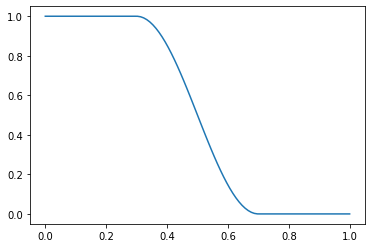

In [ ]:
p = torch.linspace(0.,1,100)
f = combine_scheds([0.3, 0.4, 0.3], [SchedLin(1.,1.), SchedCos(1.,0.), SchedLin(0.,.0), ])
plt.plot(p, [f(o) for o in p]);

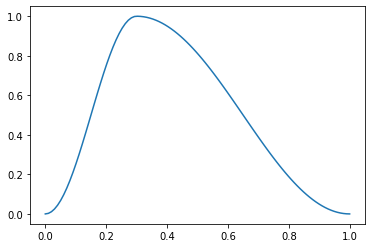

In [ ]:
p = torch.linspace(0.,1,100)
f = combine_scheds([0.3, 0.7], [SchedCos(0.,1.), SchedCos(1.,0.)])
plt.plot(p, [f(o) for o in p]);

In [ ]:
#export
@log_args
class TSStdBySampleCallback(Callback):
    "A callback to standardize each sample in a batch (optionally by_var)"
    def __init__(self, by_channel=False): self.by_var = by_var
    def before_batch(self): self.learn.xb = (TSStdBySample(self.by_var)(self.x, split_idx=0), )
    def __repr__(self): return f'TSStdBySample({self.by_channel})'

In [ ]:
#export
class ShowGraphCallback2(Callback):
    "(Modified) Update a graph of training and validation loss"
    run_after,run_valid=ProgressCallback,False

    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds")
        if not(self.run): return
        self.nb_batches = []
        assert hasattr(self.learn, 'progress')

    def after_train(self): self.nb_batches.append(self.train_iter)

    def after_epoch(self):
        "Plot validation loss in the pbar graph"
        rec = self.learn.recorder
        iters = range_of(rec.losses)
        val_losses = [v[1] for v in rec.values]
        x_bounds = (0, (self.n_epoch - len(self.nb_batches)) * self.nb_batches[0] + len(rec.losses))
        y_min = min((min(Tensor(rec.losses)), min(Tensor(val_losses))))
        y_max = max((max(Tensor(rec.losses)), max(Tensor(val_losses))))
        margin = (y_max - y_min) * .05
        y_bounds = (y_min - margin, y_max + margin)
        self.progress.mbar.update_graph([(iters, rec.losses), (self.nb_batches, val_losses)], x_bounds, y_bounds)

## Output

In [ ]:
#hide
out = create_scripts()
beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.transforms.ipynb.
Converted 003b_data.image.ipynb.
Converted 005_data.tabular.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.FCN.ipynb.
Converted 103b_models.FCNPlus.ipynb.
Converted 104_models.ResCNN.ipynb.
Converted 105_models.RNN.ipynb.
Converted 106_models.XceptionTime.ipynb.
Converted 106b_models.XceptionTimePlus.ipynb.
Converted 107_models.RNN_FCN.ipynb.
Converted 107b_models.RNN_FCNPlus.ipynb.
Converted 108_models.Transformer.ipynb.
Converted 109_models.OmniScaleCNN.ipynb.
Converted 110_models.mWDN.ipynb